In [1]:
from fastai import *
from fastai.vision import *
import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Download images from: https://pero.fit.vutbr.cz/brno_mobile_ocr_dataset  
Place all images of lines in './data/lines/lines' directory

### Prep

In [3]:
DATA_PATH = './data/lines/lines'
filenames_df = pd.DataFrame(os.listdir(DATA_PATH), columns=['image_path'])
filenames_df.head()

,image_path
0,385ff8bcbdd78e3d0dfdeac34ea4707b.jpg_rec_l0001...
1,59cd3ea8d5ce8a8dc68f3b234fa042ed.jpg_rec_l0004...
2,5124eae8ab02cc2969d8e6040e47936f.jpg_rec_l0001...
3,9926efeb1d632fd629063831280e29eb.jpg_rec_l0020...
4,efb03b607fb7519922009e94d24a4729.jpg_rec_l0036...


In [4]:
os.path.join(*DATA_PATH.split('/')[:-1], 'test.easy')

'./data/lines/test.easy'

In [5]:
char_freq = {'o': 1569888, 'n': 1515187, '-': 51382, 'b': 279917, 'a': 1618519, 'r': 1352404, 'd': 719711, ' ': 3691055, 't': 1933635, 'h': 823710, 'e': 2671469, 'U': 14351, 'S': 67271, 'C': 49024, 'O': 24728, 'R': 34837, 'N': 25202, 'A': 62811, 'D': 33051, ';': 7379, 'p': 502009, 'l': 829767, 'y': 277609, 'M': 38905, 'u': 570659, 'm': 545063, 'i': 1625694, 's': 1424148, 'c': 795754, '.': 257760, 'w': 246878, 'T': 89020, ',': 203597, 'q': 36038, 'g': 395401, 'v': 230053, 'k': 88266, '(': 40365, 'I': 57046, 'L': 26083, 'E': 37532, 'f': 458787, '[': 17465, '4': 18396, ']': 17470, 'K': 8176, 'G': 16842, ':': 19122, ')': 42422, 'F': 36152, 'x': 65094, '3': 23449, 'P': 39701, '2': 34540, 'j': 19998, 'V': 9875, 'W': 23717, 'Y': 3595, 'B': 22024, 'z': 27491, '5': 16321, '"': 8723, '1': 44710, '0': 38249, '%': 2807, 'Q': 2731, 'H': 18844, '9': 27550, '/': 6700, '6': 11875, '8': 11388, '7': 11412, 'J': 7056, "'": 13592, 'X': 4083, '=': 1268, '*': 491, '°': 274, '?': 1433, '+': 1036, '@': 249, '{': 397, '}': 332, '#': 164, 'Z': 2090, '!': 200, '$': 428, '_': 474, '§': 71, '~': 70, '©': 41, 'é': 126, '|': 68, '€': 6, '£': 49, '\\': 8, '®': 9}

In [6]:
# char_freq

In [7]:
chars = [k for k in char_freq.keys()]
label_delim = '`'
label_delim in chars

False

In [8]:
allowed_chars = set(chars + [label_delim]) - set(['©', '®', 'é'])

In [9]:
split_chars = lambda string, delim: ''.join([char+delim for char in string])[:-1]

def preprocess_string(string):
    string = string.replace('é', 'e')
    string = string.replace('©', '°')
    string = string.replace('®', '°')
    string = split_chars(string, label_delim)
    return string

split_chars('qwerty', label_delim)

'q`w`e`r`t`y'

In [160]:
# from collections import defaultdict
# chars = defaultdict(lambda: 0)

data = []
for data_split in ['train', 'valid', 'test']:
    for difficulty in ['easy', 'medium', 'hard']:
        data_info = data_split +'.'+ difficulty
        with open(os.path.join(*DATA_PATH.split('/')[:-1], data_info), "r") as f:
            lines = f.readlines()
            for line in lines:
                fn,*string = line[:-1].split(' ')
                string = ' '.join(string)
                string = preprocess_string(string)
#                 for char in string:
#                     if char not in allowed_chars:
#                         print(char)
#                         raise Exception(char + ' not in allowed chars')
#                     chars[char] +=1

                data.append((fn, string, data_info, 'valid' in data_info, 'test' in data_info, 
                             'easy' in data_info, 'medium' in data_info, 'hard' in data_info))

df = pd.DataFrame(data, columns=['image_path', 'string', 'info', 'valid', 'test', 'easy', 'medium', 'hard'])
main_df = df[ df['test'] == False ]
main_df.head()

,image_path,string,info,valid,test,easy,medium,hard
0,18256865b4b14a458cd50e19a6b6d09a.jpg_rec_l0022...,o`n`-`b`o`a`r`d` `t`h`e` `U`S`S` `C`O`R`O`N`A`...,train.easy,False,False,True,False,False
1,d2ac2da7d29d2384f6ff36e125264660.jpg_rec_l0016...,u`n`e`m`p`l`o`y`m`e`n`t` `i`n`s`u`r`a`n`c`e`.,train.easy,False,False,True,False,False
2,55ef7096ba457a8990e05dae3da29daf.jpg_rec_l0014...,b`o`u`n`d` `w`a`s` `c`a`l`c`u`l`a`t`e`d`.` `T`...,train.easy,False,False,True,False,False
3,145c6a2d996117b6453868116201e2e8.jpg_rec_l0050...,"p`r`o`c`e`s`s` `e`l`e`m`e`n`t`s`,` `s`o` `t`h`...",train.easy,False,False,True,False,False
4,30b35d49bf5250d675bdb8e92b602db3.jpg_rec_l0002...,w`e` `h`a`v`e` `t`o` `s`k`o`l`e`m`i`s`e` `b`o`...,train.easy,False,False,True,False,False


In [114]:
len(allowed_chars)

95

In [118]:
# sparse_df = main_df[400000:411000]
# sparse_df = easy_df[292736:292740]
# sparse_df

,image_path,string,info,valid,test,easy,medium,hard
292736,23b23b3075effd455439adba989f4f73.jpg_rec_l0020...,W`W`W` `f`o`r`m`s` `i`s` `i`n` `p`r`e`p`a`r`a`...,train.easy,False,False,True,False,False
292737,96a11e5098fc7f91533b1b3359de95f1.jpg_rec_l0013...,a`g`e`n`t`s` `c`a`n` `a`d`o`p`t` `a`n` `F`S`P`...,train.easy,False,False,True,False,False
403744,045d00bc3b0f29e5e9811ffb119f760b.jpg_rec_l0000...,1`7`t`h` `I`n`t`e`r`n`a`t`i`o`n`a`l` `C`o`n`f`...,valid.easy,True,False,True,False,False
403745,6c2372ae79de6d843cdc4a4a9c505b99.jpg_rec_l0050...,t`h`e` `p`o`s`e` `o`f` `t`h`e` `o`b`j`e`c`t` `...,valid.easy,True,False,True,False,False


### Fast AI Databunch

In [326]:
# label_delim = '`' # '<pad>''

USE_DEFAULT_CLASSES = True

class MultiCategoryProcessor(PreProcessor):
    "`PreProcessor` that create `classes` from `ds.items` and handle the mapping."
    def __init__(self, ds:ItemList):
        self.create_classes(ds.classes)
        self.use_default_classes = USE_DEFAULT_CLASSES
        self.default_classes = allowed_chars
        
    def create_classes(self, classes):
        self.classes = classes
        if classes is not None: self.c2i = {v:k for k,v in enumerate(classes)}

    def process_one(self,item):
        ''' list of chars from `MultiCategoryList.get()` '''
        return [ self.c2i[c] if c in self.c2i else 0 for c in item ]
    
    def process(self, ds):
        if self.classes is None: self.create_classes(self.generate_classes(ds.items))
        ds.classes = self.classes
        ds.c2i = self.c2i
        super().process(ds)

    def generate_classes(self, items):
        ''' items = [ ['h', 'e', 'l', 'l', 'o'], [...], ...] '''
        "Generate classes from `items` by taking the sorted unique values."
        if self.use_default_classes:
            classes = list(self.default_classes)
        else:
            classes = set()
            for c in items: classes = classes.union(set(c))
            classes = list(classes)
        classes.sort()
        return [label_delim] + classes # CHANGED

In [327]:
class MultiCategory(ItemBase):
    "Basic class for multi-classification labels."
    def __init__(self, data, obj, raw): self.data, self.obj, self.raw = data, obj, raw
    def __str__(self):  return label_delim.join([str(o) for o in self.obj])
    def __hash__(self): return hash(str(self))

In [328]:
def one_hot_text(x:Collection[int], c:int):
    "One-hot encode `x` with `c` classes."
    ''' x w/ len of n returns [n,c] shape arr '''
    res = np.zeros((len(x),c), np.float32)
    res[np.arange(len(x)), listify(x)] = 1.
    return res

In [329]:
# doc(CategoryListBase)

In [330]:
class MultiCategoryList(ItemList):
    "Basic `ItemList` for multi-classification labels."
    _processor = MultiCategoryProcessor
    def __init__(self, items:Iterator, classes:Collection=None, label_delim:str=None, one_hot:bool=False, **kwargs):
        self.classes = classes
        items = [line.split(label_delim) for line in items] # CHANGED
        super().__init__(items, **kwargs)
        self.processor = [MultiCategoryProcessor(self)]

    def get(self, i):
        o = self.items[i] # list of ints that represent chars
        return MultiCategory(tensor(o), [self.classes[p] for p in o], o) # CHANGED

    def analyze_pred(self, pred, thresh:float=0.5):
        return (pred >= thresh).float()

    def reconstruct(self, data_out):
        if isinstance(data_out, list): # output of data
            t_argmax, _, lengths = data_out
        else: # output from nn
            t_argmax = torch.argmax(data_out, axis=-1) # CHANGED
#         t = data_out[0] if isinstance(data_out, list) else data_out # if train mode it returns tuple
        ''' t [n,c] tensor '''
        o = [int(i) for i in t_argmax] # CHANGED
        return MultiCategory(one_hot_text(o, self.c), [self.classes[p] for p in o], o)
    
    @property
    def c(self): return len(self.classes)

In [331]:
# NOTE: make sure crnn is initialized (to make im2seq_data_collate work) ()
# it needs image_width2seq_len method which needs cnn model

crnn = CRNN(nclass=10)
image_width2seq_len = lambda w: conv_output(w, crnn.strides, crnn.padding, crnn.kernels)
# image_width2seq_len(129)

def im2seq_data_collate(batch:ItemsList, pad_idx:int=0)->Tensor:
    "Convert `batch` items to tensor data."
    data = to_data(batch) # list of (image, text) pairs
    # image: [3,48,w], text: [n,c], where n's and w's are different
    max_w = max([image.shape[2] for image, text in data])
    max_h = max([image.shape[1] for image, text in data])
    max_n = max([text.shape[0] for image, text in data])
#     _, num_classes = data[0][1].shape
    
    images = torch.zeros(len(batch), 3, max_h, max_w)
#     texts = torch.zeros(len(batch), max_n, num_classes)
    texts = []
    nn_out_seq_len, texts_len = [], []
    for i, (image, text) in enumerate(data):
        c,h,w = image.shape
        images[i, : , : , :w ] = image
        images[i, : , : , w: ] = image[:,:,w-1].unsqueeze(2).expand(c,h,max_w-w)
        nn_out_seq_len.append( image_width2seq_len(w) )
        n = text.size(0)
        texts.append( tensor(text) )
#         texts[i, :n , : ] = tensor(text)
#         texts[i, n: , -1 ] = 1
        texts_len.append(n)
#     texts = torch.cat(texts, axis=0)
    return images, (texts, tensor(nn_out_seq_len).type(torch.int), tensor(texts_len).type(torch.int))

In [332]:
def str2lines(string, n=50):
    return ''.join([s+'\n' if (i+1)%n == 0 else s for i,s in enumerate(string)])

str2lines('asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasd')

'asdasdasdasdasdasdasdasdasdasdasdasdasdasdasdasdas\ndasdasdasdasdasdasdasd'

In [333]:
class MyImageList(ImageList):
    def show_xys(self, xs, ys, imgsize:int=4, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show the `xs` (inputs) and `ys` (targets) on a figure of `figsize`."
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize) # CHANGED rows -> 1
        for x,y,ax in zip(xs, ys, axs.flatten()): x.show(ax=ax, y=y, **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
        plt.tight_layout()
        
    def show_xyzs(self, xs, ys, zs, imgsize:int=20, figsize:Optional[Tuple[int,int]]=None, **kwargs):
        "Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`."
#         if self._square_show_res:
        title = 'Ground truth\nPredictions'
        rows = int(np.ceil(math.sqrt(len(xs))))
        axs = subplots(rows, 1, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=12) # CHANGED rows -> 1
        for x,y,z,ax in zip(xs,ys,zs,axs.flatten()):
            x.show(ax=ax, title=f'y_true: {str2lines(str(y))}\n\ny_pred: {str2lines(str(z))}', **kwargs)
        for ax in axs.flatten()[len(xs):]: ax.axis('off')
#         else:
#             title = 'Ground truth/Predictions'
#             axs = subplots(len(xs), 2, imgsize=imgsize, figsize=figsize, title=title, weight='bold', size=14)
#             for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
#                 x.show(ax=axs[i,0], y=y, **kwargs)
#                 x.show(ax=axs[i,1], y=z, **kwargs)

In [334]:
def create_data(df, bs=32):
    ''' DataFrame (df) -> Dataloader (dl) '''
    data = (MyImageList.from_df(df, path=DATA_PATH, cols='image_path')
        .split_from_df(col='valid')
        .label_from_df(cols='string', label_cls=MultiCategoryList, label_delim=label_delim)
        .databunch(bs=bs, collate_fn=im2seq_data_collate)
#         .normalize()
    )
    return data

In [335]:
# NOTE: there are no {'\\', '£', '€'} in easy_df
easy_df = main_df[ main_df['easy'] ]
easy_df

,image_path,string,info,valid,test,easy,medium,hard
0,18256865b4b14a458cd50e19a6b6d09a.jpg_rec_l0022...,o`n`-`b`o`a`r`d` `t`h`e` `U`S`S` `C`O`R`O`N`A`...,train.easy,False,False,True,False,False
1,d2ac2da7d29d2384f6ff36e125264660.jpg_rec_l0016...,u`n`e`m`p`l`o`y`m`e`n`t` `i`n`s`u`r`a`n`c`e`.,train.easy,False,False,True,False,False
2,55ef7096ba457a8990e05dae3da29daf.jpg_rec_l0014...,b`o`u`n`d` `w`a`s` `c`a`l`c`u`l`a`t`e`d`.` `T`...,train.easy,False,False,True,False,False
3,145c6a2d996117b6453868116201e2e8.jpg_rec_l0050...,"p`r`o`c`e`s`s` `e`l`e`m`e`n`t`s`,` `s`o` `t`h`...",train.easy,False,False,True,False,False
4,30b35d49bf5250d675bdb8e92b602db3.jpg_rec_l0002...,w`e` `h`a`v`e` `t`o` `s`k`o`l`e`m`i`s`e` `b`o`...,train.easy,False,False,True,False,False
...,...,...,...,...,...,...,...,...
442164,3132b7ece56a7040c878fa31175c1171.jpg_rec_l0013...,t`o` `c`o`m`p`a`r`e` `i`t` `q`u`a`n`t`i`t`a`t`...,valid.easy,True,False,True,False,False
442165,64ebbdfed227f9d6dff17a40b4c3d088.jpg_rec_l0023...,c`o`n`v`e`r`t` `a`n` `a`b`s`o`l`u`t`e` `v`a`l`...,valid.easy,True,False,True,False,False
442166,55a5d7253836d4cb9d46778ab0c1c3e4.jpg_rec_l0028...,p`u`t` `i`s` `s`t`o`c`h`a`s`t`i`c` `a`n`d` `n`...,valid.easy,True,False,True,False,False
442167,b6eff21e9ce0200fc760238cf3ef0ea8.jpg_rec_l0043...,a` `g`i`v`e`n` `s`e`q`u`e`n`c`e` `o`f` `f`r`a`...,valid.easy,True,False,True,False,False


### Dataloaders for testing

In [403]:
valid_dls = {}
for difficulty in tqdm(['easy', 'medium', 'hard']):
    temp_df = main_df.copy()
    temp_df['valid'] = (main_df[difficulty] == True) & (main_df['valid'] == True)
    valid_dls[difficulty] = create_data(temp_df).valid_dl

In [404]:
len(valid_dls['easy']), len(valid_dls['medium']), len(valid_dls['hard']) # total = this * batch_size

(1201, 372, 56)

### Train data

In [336]:
data = create_data(easy_df, bs=16)
data

ImageDataBunch;

Train: LabelList (292738 items)
x: MyImageList
Image (3, 48, 641),Image (3, 48, 294),Image (3, 48, 721),Image (3, 48, 538),Image (3, 48, 879)
y: MultiCategoryList
o`n`-`b`o`a`r`d` `t`h`e` `U`S`S` `C`O`R`O`N`A`D`O`;` `a` `d`e`p`l`o`y`a`b`l`e` `C`M`O`C,u`n`e`m`p`l`o`y`m`e`n`t` `i`n`s`u`r`a`n`c`e`.,b`o`u`n`d` `w`a`s` `c`a`l`c`u`l`a`t`e`d`.` `T`h`e` `u`p`p`e`r` `b`o`u`n`d` `w`a`s` `c`a`l`c`u`l`a`t`e`d` `b`y,p`r`o`c`e`s`s` `e`l`e`m`e`n`t`s`,` `s`o` `t`h`a`t` `t`h`e` `r`e`q`u`e`s`t`o`r` `a`g`e`n`t,w`e` `h`a`v`e` `t`o` `s`k`o`l`e`m`i`s`e` `b`o`t`h` `u`s`i`n`g` `t`h`e` `s`a`m`e` `s`k`o`l`e`m` `c`o`n`s`t`a`n`t`s` `(`w`h`i`c`h` `r`e`s`u`l`t`s` `i`n` `t`h`e
Path: data/lines/lines;

Valid: LabelList (38425 items)
x: MyImageList
Image (3, 48, 818),Image (3, 48, 436),Image (3, 48, 941),Image (3, 48, 496),Image (3, 48, 659)
y: MultiCategoryList
1`7`t`h` `I`n`t`e`r`n`a`t`i`o`n`a`l` `C`o`n`f`e`r`e`n`c`e` `o`n` `A`r`t`i`f`i`c`i`a`l` `R`e`a`l`i`t`y` `a`n`d` `T`e`l`e`x`i`s`t`e`n`c`e` `2`0

In [337]:
data.c

96

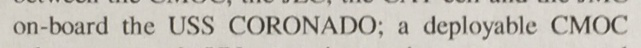

In [338]:
data.x[0]

In [339]:
data.y[0]

MultiCategory o`n`-`b`o`a`r`d` `t`h`e` `U`S`S` `C`O`R`O`N`A`D`O`;` `a` `d`e`p`l`o`y`a`b`l`e` `C`M`O`C

In [340]:
data.y[0].data

tensor([76, 75, 13, 63, 76, 62, 79, 65,  1, 81, 69, 66,  1, 51, 49, 49,  1, 33,
        45, 48, 45, 44, 31, 34, 45, 27,  1, 62,  1, 65, 66, 77, 73, 76, 86, 62,
        63, 73, 66,  1, 33, 43, 45, 33])

### Model

In [341]:
class LSTM(nn.Module):

    def __init__(self, input_size, num_hidden, num_output, bidirectional=True):
        super(LSTM, self).__init__()
        
        self.rnn = nn.LSTM(input_size, num_hidden, bidirectional=bidirectional)
        mult = 1 if not bidirectional else 2
        self.embedding = nn.Linear(num_hidden * mult, num_output)

    def forward(self, input):
        # input: (seq_len, batch, input_size)
        recurrent, _ = self.rnn(input) # [s, b, h]
        output = self.embedding(recurrent)  # [s, b, out]
        
#         s, b, h = recurrent.size()
#         t_rec = recurrent.view(s * b, h)
#         output = self.embedding(t_rec)  # [T * b, nOut]
#         output = output.view(s, b, -1)
        
        # output: (seq_len, batch, output_size)
        return output

LSTM(10, num_hidden=20, num_output=100)(torch.zeros(100,100,10)).shape

torch.Size([100, 100, 100])

In [342]:
def conv_output(w, ss, ps=None, ks=3):
    ''' image width, strides, pools, kernel sizes '''
    for s,p,k in zip(ss,ps,ks):
        s = s[1] if isinstance(s, tuple) else s
        w = w if w%s == 0 else w + 1
        w = (w - k + 2*p)/s + 1 if p is not None else w/s
    return int(w)

conv_output(129, [2, 1, 2, 1, (2,1), (2,1), 1], [None] * 6 + [0], [3, 3, 3, 3, 3, 3, 3])

31

In [343]:
class CRNN(nn.Module):

    def __init__(self, nclass, nc=3, nh=256, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        self.nclass = nclass
        kernels = [3, 3, 3, 3, 3, 3, 3]
        strides = [2, 1, 2, 1, (2,1), (2,1), 1]
        channels = [64, 128, 256, 256, 512, 512, 512]
        padding = [None] * 6 + [0] # None - out size doesnt change
        
        self.kernels, self.strides, self.channels, self.padding = kernels, strides, channels, padding
        
        layers = []
        for i,o,k,s,p in zip([3] + channels[:-1], channels, kernels, strides, padding):
            layers.append( conv_layer(ni=i, nf=o, ks=k, stride=s, padding=p) )
            
        self.cnn = nn.Sequential(*layers)
        
        self.rnn = nn.Sequential(LSTM(512, nh, nh), LSTM(nh, nh, nclass))
        
        self.linear = nn.Linear(512, nclass)
        
#     def eval(self): # (quick fix) model.eval() returns bad outputs w/ BatchNorm 
#         return self

    def forward(self, x): # input: [b, 1, h, w]
        # output: ([b,s,c], [b]) (output, seq lengths)
        x = self.cnn(x) # [b,512,1,w/4-2]
        b, c, h, w = x.size()
        assert h == 1, "the height of conv must be 1"
        # [b,512,1,w] -> [s,b,512] (w == s)
        x = x.squeeze(2).permute(2, 0, 1) # [b,c,w] (w == s)
        # [s,b,512] -> [s,b,c]
        x = self.rnn(x)
#         x = self.linear(x)
#         nn_output = (x, pad_mask)
        return x.permute(1,0,2)

CRNN(nclass=10)(torch.zeros(2,3,48,128)).shape

torch.Size([2, 30, 10])

In [344]:
crnn = CRNN(nclass=10)
image_width2seq_len = lambda w: conv_output(w, crnn.strides, crnn.padding, crnn.kernels)
image_width2seq_len(129)

31

### Learner

In [345]:
crnn = CRNN(nclass=data.c)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
# _ = crnn.apply(weights_init)

In [347]:
pad_idx = data.classes.index(label_delim)
ctc_loss = nn.CTCLoss(blank=pad_idx, reduction='mean', zero_infinity=True)

def loss_func(y_pred, y_true, y_pred_len, y_true_len):
    # y_pred: [b,s_e,c], y_true: [[s_d], [s_d], ...], lengths: [b]
    b, s_e, c = y_pred.shape
    y_true = torch.cat(y_true, axis=0) # [b*s_d]
    y_pred = y_pred.log_softmax(axis=2).permute(1,0,2) # [ s_e, b, c ]
    torch.backends.cudnn.enabled = False
    loss = ctc_loss(y_pred, y_true, y_pred_len, y_true_len)
    torch.backends.cudnn.enabled = True
    return loss

In [348]:
def print_metric(y_pred, y_true):
#     o = y_pred.argmax(-1)[0].cpu().numpy()
#     print('PRED:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
#     o = y_true.argmax(-1)[0].cpu().numpy()
#     print('TRUE:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
    return tensor(0)

In [383]:
learner = Learner(data, crnn, loss_func=loss_func, path='./models', # model path
#                   opt_func = lambda input_: AdamW(input_, correct_bias=False), 
                  metrics=[])
learner.callbacks.append(ShowGraph(learner))

# learner.show_results(DatasetType.Train, rows=1)

In [392]:
# NOTE: to save/load there is 2 options:
# 1. save state (saved in './models/models/')

# learner.save('crnn')
# learner.load('crnn')

# 2. save exported model for inference (saved in './models/')

# learner.export('crnn_exported')
# load_learner(path='./models', file='crnn_exported')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.32E-03


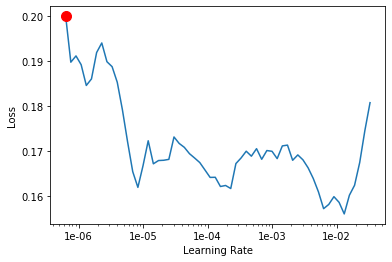

In [384]:
learner.lr_find()
learner.recorder.plot(skip_end=7,suggestion=True)

In [424]:
learner.fit_one_cycle(1, max_lr=1e-4)

In [450]:
learner.save('crnn')

In [449]:
learner.export('crnn_exported')

### Examples

In [428]:
learner = Learner(data, CRNN(data.c), loss_func=loss_func, path='./models', metrics=[]).load('crnn')

In [1258]:
# learner.show_results(DatasetType.Train, rows=1) # DOESNT WORK

In [429]:
def decode(texts, classes=data.classes):
    """ convert text-index into text-label. """
    out = []
    index = 0
    for t in texts:
        char_list = []
        for i in range(len(t)):
            if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):  # removing repeated characters and blank.
                char_list.append(t[i])
#         text = ''.join(char_list)

        out.append(tensor(char_list))
    return out

In [430]:
dl = iter(valid_dls['easy'])

In [448]:
''.join([data.classes[i] for i in decode([o])[0]])

'generating at least some of these complex mappings. However, suggesting a template for a mapping expression which'

PRED: ``````g`````e`````n`````e`````r```a`````t`i`i```n`````g`g``` ` ```a```t``` ` `l`````e```a`a```s```t`t``` ```s`````o`````m`````````e````` ```o`o```f``` ` `t`t`h`h`````e`````s`````e``` ` ```c`````o`````m`````````p`````l```e`````x````` ` ```m`````````a`````p`````p`````i```n`n```g`g`````s```.` ` ```H`````````o`````w`````````e`````v`````e```r`r```,` ` ```s`````u`````g`````g`g`````e```s```t`t`i`i```n`````g`g``` ` ```a``` ` `t`````e```m`m```````p`p```l`````a```t```e`e``` ` `f`````o```r`r``` ` `a````` ` ```m`````````a`````p`````p`````i```n`````g`g``` ` ```e`````x`````p`````r`````e```s`s```s```i`i```o`````n````` ` ```w`````h`h`````i```c`````h``````````````
TRUE: g`e`n`e`r`a`t`i`n`g` `a`t` `l`e`a`s`t` `s`o`m`e` `o`f` `t`h`e`s`e` `c`o`m`p`l`e`x` `m`a`p`p`i`n`g`s`.` `H`o`w`e`v`e`r`,` `s`u`g`g`e`s`t`i`n`g` `a` `t`e`m`p`l`a`t`e` `f`o`r` `a` `m`a`p`p`i`n`g` `e`x`p`r`e`s`s`i`o`n` `w`h`i`c`h


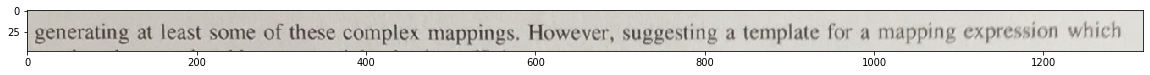

In [441]:
model = learner.model
model = model.eval()
a = next(dl)
i = 1
y_pred = model(a[0])
o = y_pred.argmax(-1)[i].cpu().numpy()
print('PRED:', MultiCategory(one_hot_text(o, data.c), [data.classes[p] for p in o], o))
print('TRUE:', MultiCategory(a[1], [data.classes[p] for p in a[1][0][i]], o))
plt.figure(figsize = (20,2))
_ = plt.imshow(a[0][i].permute(1,2,0).cpu().numpy(), interpolation='nearest')

### Eval

In [432]:
def calc_precision_recall(true_words, pred_words):
    num_preds, num_trues = len(pred_words), len(true_words)
    
    correct = 0
    for true_word in true_words:
        if true_word in pred_words:
            pred_words.remove(true_word)
            correct += 1
            continue

    precision = correct / num_preds
    recall = correct / num_trues
    # print(precision, recall, correct, num_preds)
    return precision, recall

In [433]:
def wer(s1,s2):
    ''' s1 - true text, s2 - pred text '''
    d = np.zeros([len(s1)+1,len(s2)+1])
    d[:,0] = np.arange(len(s1)+1)
    d[0,:] = np.arange(len(s2)+1)

    for j in range(1,len(s2)+1):
        for i in range(1,len(s1)+1):
            if s1[i-1] == s2[j-1]:
                d[i,j] = d[i-1,j-1]
            else:
                d[i,j] = min(d[i-1,j]+1, d[i,j-1]+1, d[i-1,j-1]+1)

    return d[-1,-1]/len(s1)

word_error = wer( 'black frog jumped away'.split(' '), 'black frog jumped awayyy'.split(' ') )
char_error = wer( 'black frog jumped away', 'black frog jumped awayyy' )
char_error, word_error

(0.09090909090909091, 0.25)

In [434]:
def idx2text(indexes):
    for i in indexes:
        try:
            data.classes[i]
        except:
            print('asd', i)
    return ''.join([data.classes[i] for i in indexes])

In [435]:
def evaluate_model(model, dl, t2list=lambda t: list(t.cpu().numpy()), total=None):
    total = len(dl) if total is None else total
    ps, rs, ws, cs = [], [], [], []
    for images, (texts, im_lens, text_lens) in tqdm(iter(dl), total=total):
        y_pred = model(images).argmax(-1)
        pred_texts = decode(y_pred)
        for true_words, pred_words in zip(texts, pred_texts): # go through batch
            true_words, pred_words = t2list(true_words), t2list(pred_words)
            true_str, pred_str = idx2text(true_words), idx2text(pred_words)
            p,r = calc_precision_recall(true_words, pred_words)
            c = wer(true_str, pred_str)
            w = wer(true_str.split(' '), pred_str.split(' '))
            ps.append(p); rs.append(r); ws.append(w); cs.append(c)
    return np.array(ps), np.array(rs), np.array(ws), np.array(cs)

# p, r, w, c = evaluate_model(learner.model.train(), data.valid_dl)

In [436]:
model = learner.model.eval()

In [439]:
p, r, w, c = evaluate_model(model, valid_dls['easy'])
c.mean(), w.mean(), p.mean(), r.mean()

(0.010869185466280502,
 0.0464731053252202,
 0.9921651441767915,
 0.9924249771710288)

In [438]:
p, r, w, c = evaluate_model(model, valid_dls['medium'])
c.mean(), w.mean(), p.mean(), r.mean()

(0.14536296892645892,
 0.41660727441948536,
 0.9119427285550357,
 0.903531098792705)

In [437]:
p, r, w, c = evaluate_model(model, valid_dls['hard'])
c.mean(), w.mean(), p.mean(), r.mean()

(0.539507447840884, 0.9313218057082575, 0.716972570661273, 0.6759358122278971)